# Sparkify Project 

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import asc, desc, udf, sum, round, col
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('sparkify').getOrCreate()

# Load and Clean Dataset

In [3]:
user_log = spark.read.json('mini_sparkify_event_data.json')

In [4]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
# drop invalid and missing values
user_log = user_log.dropna(how='any', subset=['userId', 'sessionId'])
user_log_valid = user_log.filter(user_log.userId != '')

# Exploratory Data Analysis

In [6]:
user_log_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# get the hour each song is played
get_hour = udf(lambda x: datetime.fromtimestamp(x / 1000.0).hour, IntegerType())
user_log_valid = user_log_valid.withColumn('hour', get_hour(user_log_valid.ts))

In [8]:
user_log_valid.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [9]:
# define churn
churn_users = user_log_valid.filter(user_log_valid.page == 'Cancellation Confirmation') \
                            .select('userId') \
                            .dropDuplicates().collect()

churn_user_id = [i['userId'] for i in churn_users]

In [10]:
if_churn = udf(lambda x: 1 if x in churn_user_id else 0, IntegerType())
user_log_valid = user_log_valid.withColumn('churn', if_churn(user_log_valid.userId))

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
# the distribution of hours that songs are played
hour_of_song = user_log_valid.filter(user_log_valid.page == 'NextSong').groupby('hour').count().sort('hour')
hour_of_song_pd = hour_of_song.toPandas()

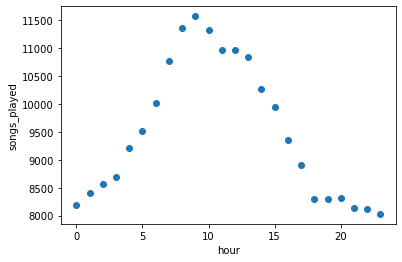

In [12]:
plt.scatter(hour_of_song_pd['hour'], hour_of_song_pd['count']);
plt.xlabel('hour');
plt.ylabel('songs_played');

people usually play songs between 9am-12pm.

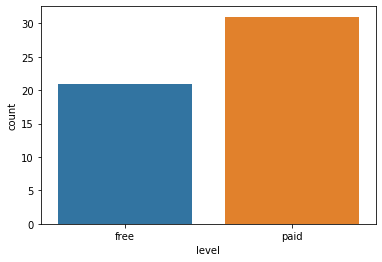

In [13]:
# paid or free distribution for churn
paid_or_free = user_log_valid.filter(user_log_valid['page'] == 'Cancellation Confirmation') \
                             .dropDuplicates(['userId']) \
                             .groupby('level').count()

paid_or_free_pd = paid_or_free.toPandas()
sns.barplot(x='level', y='count', data=paid_or_free_pd)

Although the number of paid users is more than free users, but it's not statistically significant.

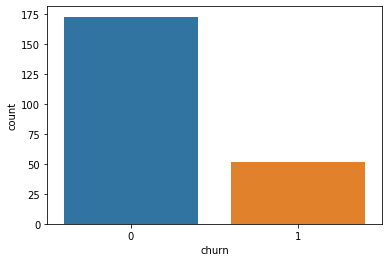

In [14]:
# distribution for churn and nochurn
churn_nochurn = user_log_valid.dropDuplicates(['userId']).groupby('churn').count()
churn_nochurn_pd = churn_nochurn.toPandas()
sns.barplot(x='churn', y='count', data=churn_nochurn_pd)

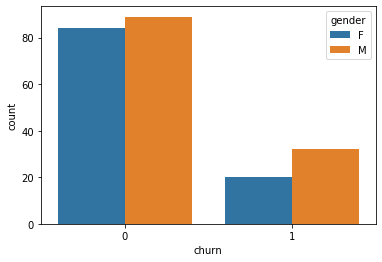

In [15]:
# gender distribution for churn and nochurn
gender_churn = user_log_valid.dropDuplicates(['userId']).groupby('churn', 'gender').count()
gender_churn_pd = gender_churn.toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=gender_churn_pd)

In [16]:
# page frequency for churn and nochurn users

In [17]:
num_churn_log = user_log_valid.filter(user_log_valid.churn == True).count()
num_non_churn_log = user_log_valid.filter(user_log_valid.churn == False).count()
print('number of churn log: {}'.format(num_churn_log))
print('number of not churn log: {}'.format(num_non_churn_log))

number of churn log: 44864
number of not churn log: 233290


In [18]:
# page frequency for churns
churn_log = user_log_valid.filter((user_log_valid.churn == True) & (user_log_valid.page != 'NextSong')) \
                          .groupby('page').count()
churn_log = churn_log.withColumn('churn_freq', round(churn_log['count'] / num_churn_log * 100, 2)) \
                     .sort('page')

# page frequency for nochurns
not_churn_log = user_log_valid.filter((user_log_valid.churn == False) & (user_log_valid.page != 'NextSong')) \
                              .groupby('page').count()
not_churn_log = not_churn_log.withColumn('nochurn_freq', round(not_churn_log['count'] / num_non_churn_log * 100, 2)) \
                             .sort('page')

# join churns and nochurns
all_page_freq = churn_log.join(not_churn_log, "page", "outer").drop('count').fillna(0)

In [19]:
all_page_freq.show(10)

+--------------------+----------+------------+
|                page|churn_freq|nochurn_freq|
+--------------------+----------+------------+
|              Cancel|      0.12|         0.0|
|    Submit Downgrade|      0.02|        0.02|
|         Thumbs Down|      1.11|        0.88|
|                Home|      3.73|         3.6|
|           Downgrade|      0.75|        0.74|
|         Roll Advert|      2.16|        1.27|
|              Logout|      1.23|        1.15|
|       Save Settings|      0.13|        0.11|
|Cancellation Conf...|      0.12|         0.0|
|               About|      0.12|        0.19|
+--------------------+----------+------------+
only showing top 10 rows



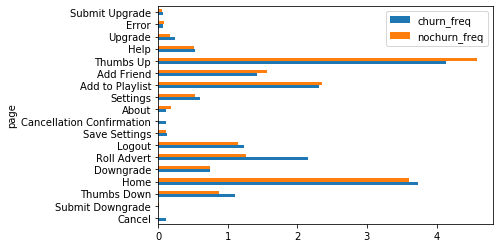

In [20]:
all_page_freq_pd = all_page_freq.toPandas()
all_page_freq_pd.plot.barh('page')

As the figure shows above, nochurn users click 'Thumbs Up', 'Add Friend', 'Add to Playlist' more than churn users; churn users click 'Roll Advert' and 'Thumbs Down' more than nochurn users.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. 

### The feature I choose:
1. The number of songs each user played
2. The number of errors each user encountered 
3. The number of friends each user added
4. The number of roll advert each user added
5. The number of songs each user added in playlist
6. The number of thumbs up each user clicked
7. The number of thumbs down each user clicked
8. The span of time since registration for each user
9. The total listening time for each user
10. The average number of songs each user played per session

In [21]:
user_page_features = user_log_valid.groupby('userId') \
                    .pivot('page', ['NextSong', 'Error', 'Add Friend', 'Roll Advert',\
                                    'Add to Playlist', 'Thumbs Up', 'Thumbs Down']) \
                    .count() \
                    .fillna(0) \
                    .sort('userId') \
                    .withColumnRenamed('NextSong', 'Songs') \
                    .withColumnRenamed('Add to Playlist', 'Playlist_Add')

In [22]:
user_page_features.show(10)

+------+-----+-----+----------+-----------+------------+---------+-----------+
|userId|Songs|Error|Add Friend|Roll Advert|Playlist_Add|Thumbs Up|Thumbs Down|
+------+-----+-----+----------+-----------+------------+---------+-----------+
|    10|  673|    0|        12|          1|           9|       37|          4|
|   100| 2682|    3|        49|         25|          61|      148|         27|
|100001|  133|    1|         2|         14|           3|        8|          2|
|100002|  195|    0|         1|          3|           5|        5|          0|
|100003|   51|    0|         0|          9|           2|        3|          0|
|100004|  942|    2|        19|         86|          23|       35|         11|
|100005|  154|    0|         3|         18|           3|        7|          3|
|100006|   26|    0|         4|          3|           1|        2|          2|
|100007|  423|    0|        17|          5|           9|       19|          6|
|100008|  772|    0|        17|         20|         

In [23]:
# the span of time since registration
time_span = user_log_valid.select('userId', 'ts', 'registration')\
                          .withColumn('span', user_log_valid.ts - user_log_valid.registration)\
                          .groupby('userId')\
                          .agg({'span': 'max'})\
                          .select('userId', round(col('max(span)') / 1000 / 3600 / 24).alias('span'))                     

In [24]:
time_span.show(10)

+------+-----+
|userId| span|
+------+-----+
|100010| 56.0|
|200002| 70.0|
|   125| 71.0|
|    51| 19.0|
|   124|132.0|
|     7| 73.0|
|    54|111.0|
|    15| 57.0|
|   155| 24.0|
|   132| 67.0|
+------+-----+
only showing top 10 rows



In [25]:
# total listen time
listen_time = user_log_valid.select('userId', 'length').groupby('userId').sum()\
                            .withColumnRenamed('sum(length)', 'listen_time')\
                            .withColumn('listen_time', round(col('listen_time')))

In [26]:
listen_time.show(10)

+------+-----------+
|userId|listen_time|
+------+-----------+
|100010|    66941.0|
|200002|    94009.0|
|   125|     2089.0|
|    51|   523276.0|
|   124|  1012312.0|
|     7|    38034.0|
|    54|   711345.0|
|    15|   477308.0|
|   155|   198779.0|
|   132|   483119.0|
+------+-----------+
only showing top 10 rows



In [27]:
# the average number of songs played per session
avg_songs = user_log_valid.filter(user_log_valid.page == 'NextSong') \
                          .groupby('userId', 'sessionId').count() \
                          .sort('userId', 'sessionId') \
                          .groupby('userId').agg({'count': 'avg'}) \
                          .withColumnRenamed('avg(count)', 'avg_song') \
                          .withColumn('avg_song', round(col('avg_song'), 2))

In [28]:
avg_songs.show(10)

+------+--------+
|userId|avg_song|
+------+--------+
|100010|   39.29|
|200002|    64.5|
|   125|     8.0|
|   124|  145.68|
|    51|   211.1|
|     7|   21.43|
|    15|  136.71|
|    54|   81.17|
|   155|  136.67|
|100014|   42.83|
+------+--------+
only showing top 10 rows



In [29]:
# the output label of the dataset
churn_ornot = user_log_valid.select(['userId', 'churn']).dropDuplicates()

In [30]:
churn_ornot.show(10)

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
|200002|    0|
|    30|    0|
|     8|    0|
|100011|    1|
|100012|    1|
+------+-----+
only showing top 10 rows



### Put all features together

In [31]:
features = [time_span, listen_time, avg_songs, churn_ornot]

In [32]:
def join_features(feature, other_features):
    for i in other_features:
        feature = feature.join(i, 'userId', 'left')
    feature = feature.sort('userId')
    return feature

In [33]:
features_final = join_features(user_page_features, features)

In [34]:
features_final.show(10)

+------+-----+-----+----------+-----------+------------+---------+-----------+-----+-----------+--------+-----+
|userId|Songs|Error|Add Friend|Roll Advert|Playlist_Add|Thumbs Up|Thumbs Down| span|listen_time|avg_song|churn|
+------+-----+-----+----------+-----------+------------+---------+-----------+-----+-----------+--------+-----+
|    10|  673|    0|        12|          1|           9|       37|          4| 52.0|   166866.0|  112.17|    0|
|   100| 2682|    3|        49|         25|          61|      148|         27| 65.0|   672878.0|   78.88|    0|
|100001|  133|    1|         2|         14|           3|        8|          2| 45.0|    35074.0|   33.25|    1|
|100002|  195|    0|         1|          3|           5|        5|          0|160.0|    49560.0|   48.75|    0|
|100003|   51|    0|         0|          9|           2|        3|          0| 23.0|    12306.0|    25.5|    1|
|100004|  942|    2|        19|         86|          23|       35|         11|172.0|   231480.0|    47.1

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [35]:
# assemble features to fit the model
columns = ['Songs','Error','Add Friend','Roll Advert', 'Playlist_Add','Thumbs Up','Thumbs Down',
         'span','listen_time','avg_song']
Assembler = VectorAssembler(inputCols=columns, outputCol='Features')
features_final = Assembler.transform(features_final)

In [36]:
features_final.head()

Row(userId='10', Songs=673, Error=0, Add Friend=12, Roll Advert=1, Playlist_Add=9, Thumbs Up=37, Thumbs Down=4, span=52.0, listen_time=166866.0, avg_song=112.17, churn=0, Features=DenseVector([673.0, 0.0, 12.0, 1.0, 9.0, 37.0, 4.0, 52.0, 166866.0, 112.17]))

In [37]:
# normalize the data
scaler = StandardScaler(inputCol="Features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

In [38]:
scaler_model = scaler.fit(features_final)
features_final = scaler_model.transform(features_final)

In [39]:
# extract useful columns
use_data = features_final.select(features_final.churn.alias("label"),\
                                 features_final.scaledFeatures.alias("features"))

In [40]:
use_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.6090713924531,...|
|    0|[2.42723547482795...|
|    1|[0.12036626329310...|
|    0|[0.17647685219666...|
|    1|[0.04615548442066...|
|    0|[0.85251894753465...|
|    1|[0.13937146276044...|
|    1|[0.02353024695955...|
|    1|[0.38281901784199...|
|    0|[0.69866733279909...|
|    1|[0.46879492019421...|
|    0|[0.24887761207221...|
|    1|[0.00995510448288...|
|    1|[0.43078452125954...|
|    1|[1.02356574274064...|
|    1|[0.23258744110021...|
|    1|[0.72400759875554...|
|    0|[0.47965503417554...|
|    1|[0.04706049391911...|
|    0|[0.90681951744131...|
+-----+--------------------+
only showing top 20 rows



In [41]:
train, test = use_data.randomSplit([0.8, 0.2], seed=33)

### Logistic Regression

In [42]:
# initialize model and evaluator
lr = LogisticRegression(maxIter=10)
f1_score = MulticlassClassificationEvaluator(metricName='f1')

# build a parameter grid
paramGrid = ParamGridBuilder().build()
crossval_lr = CrossValidator(estimator=lr, evaluator=f1_score, estimatorParamMaps=paramGrid, numFolds=3)

In [43]:
lr_model = crossval_lr.fit(train)
lr_result = lr_model.transform(test)

In [44]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Accuracy")
print(evaluator.evaluate(lr_result, {evaluator.metricName: "accuracy"}))
print("F-1 score")
print(evaluator.evaluate(lr_result, {evaluator.metricName: "f1"}))

Accuracy
0.8222222222222222
F-1 score
0.8015037593984963


### Random Forest

In [45]:
# initialize the model and evaluator
rfc = RandomForestClassifier()
f1_score = MulticlassClassificationEvaluator(metricName='f1')

# build a parameter grid
paramGrid = ParamGridBuilder().build()
crossval_rfc = CrossValidator(estimator=rfc, evaluator=f1_score, estimatorParamMaps=paramGrid, numFolds=3)

In [46]:
rfc_model = crossval_rfc.fit(train)
rfc_result = rfc_model.transform(test)

In [47]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Accuracy")
print(evaluator.evaluate(rfc_result, {evaluator.metricName: "accuracy"}))
print("F-1 score")
print(evaluator.evaluate(rfc_result, {evaluator.metricName: "f1"}))

Accuracy
0.8222222222222222
F-1 score
0.8015037593984963


### Gradient Boosted Tree

In [48]:
# initialize the model and evaluator
gbdt = GBTClassifier(maxIter=10, seed=33)
f1_score = MulticlassClassificationEvaluator(metricName='f1')

# build a parameter grid
paramGrid = ParamGridBuilder().build()
crossval_gbdt = CrossValidator(estimator=gbdt, evaluator=f1_score, estimatorParamMaps=paramGrid, numFolds=3)

In [49]:
gbdt_model = crossval_gbdt.fit(train)
gbdt_result = gbdt_model.transform(test)

In [50]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Accuracy")
print(evaluator.evaluate(gbdt_result, {evaluator.metricName: "accuracy"}))
print("F-1 score")
print(evaluator.evaluate(gbdt_result, {evaluator.metricName: "f1"}))

Accuracy
0.7777777777777778
F-1 score
0.7668918918918919


As we can see, **Random Forest** provides the best F-1 score performance. Let's see which features are more important in this machine learning process.

### Feature Importance

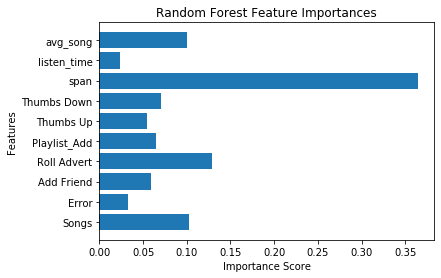

In [54]:
best_model = rfc_model.bestModel
feature_importance = best_model.featureImportances

y_value = np.arange(len(columns)) 
plt.barh(y_value, feature_importance, align='center')
plt.yticks(y_value, columns)
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Random Forest Feature Importances');

As the figure above, the most important feature for predicting churn are:

- span, the time since registration
- roll advert
- the number of thumbs down
- the number of songs added to playlist

### Test the model robustness

In [55]:
# Change the number of folds from 3 to 5 to test the robustness of the model
crossval_rfc_test = CrossValidator(estimator=rfc, evaluator=f1_score, estimatorParamMaps=paramGrid, numFolds=5)

rfc_model_test = crossval_rfc_test.fit(train)
rfc_results_test = rfc_model_test.transform(test)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("Accuracy")
print(evaluator.evaluate(rfc_results_test, {evaluator.metricName: "accuracy"}))
print("F-1 score")
print(evaluator.evaluate(rfc_results_test, {evaluator.metricName: "f1"}))

Accuracy
0.8222222222222222
F-1 score
0.8015037593984963


Therefore, the model is robust because the F-1 score maintains high although the parameters were changed.